# Example CV3 - Function fitting with a quantum neural network

In this example we show how a variational circuit can be used to learn a fit for a one-dimensional function when being trained with noisy samples from that function. 

The variational circuit we use is the continuous-variable quantum neural network model described in [Killoran et al. (2018)](https://arxiv.org/abs/1806.06871). 

### Imports

We import PennyLane, the wrapped version of NumPy provided by PennyLane, and an optimizer. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

The device we use is the Strawberry Fields simulator, this time with only one quantum mode (or `wire`). You will need to have the Strawberry Fields plugin for PennyLane installed.

In [2]:
try:
    dev = qml.device('strawberryfields.fock', wires=1, cutoff_dim=10)    
except:
    print("To run this example you need to install the strawberryfields plugin...")

### Quantum node

For a single quantum mode, each layer of the variational circuit is defined as:

In [3]:
def layer(v):

    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0., wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0., wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into the displacement of the mode, and then executes the layers. The output is the expectation of the x-quadrature.

In [4]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    
    # Encode input x into quantum state
    qml.Displacement(x, 0., wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval.X(0)

### Objective

As an objective we take the square loss between target labels and model predictions.

In [5]:
def square_loss(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2
    loss = loss / len(labels)

    return loss

In the cost function, we compute the outputs from the variational circuit. Function fitting is a regression problem, and we interpret the expectations from the quantum node as predictions (i.e., without applying postprocessing such as thresholding).

In [6]:
def cost(var, features, labels):

    preds = [quantum_neural_net(var, x=x) for x in features]

    return square_loss(labels, preds)

### Optimization

We load noisy data samples of a sine function.

In [7]:
data = np.loadtxt("data/sine.txt")
X = data[:, 0]
Y = data[:, 1]

Before training a model, let's examine the data.

*Note: For the next cell to work you need the matplotlib library.* 

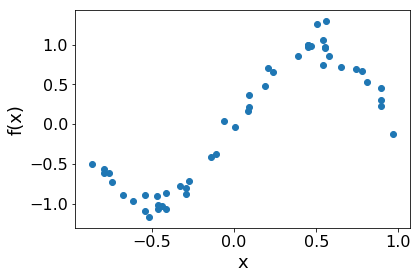

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

plt.figure()
plt.scatter(X, Y)
plt.xlabel('x', fontsize=18)
plt.ylabel('f(x)', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.show()

The network's weights (called `var` here) are initialized with values sampled from a normal distribution. We use 4 layers; performance has been found to plateau at around 6 layers.

In [9]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 5)

var_init

array([[ 0.08820262,  0.02000786,  0.0489369 ,  0.11204466,  0.0933779 ],
       [-0.04886389,  0.04750442, -0.00756786, -0.00516094,  0.02052993],
       [ 0.00720218,  0.07271368,  0.03805189,  0.00608375,  0.02219316],
       [ 0.01668372,  0.07470395, -0.01025791,  0.01565339, -0.04270479]])

Using the Adam optimizer, we update the weights for 500 steps (this takes some time). More steps will lead to a better fit.

In [10]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(500):
    var = opt.step(lambda v: cost(v, X, Y), var)
    
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X, Y)))

Iter:     1 | Cost: 0.2689702 
Iter:     2 | Cost: 0.2472125 
Iter:     3 | Cost: 0.2300139 
Iter:     4 | Cost: 0.2157100 
Iter:     5 | Cost: 0.2035455 
Iter:     6 | Cost: 0.1931103 
Iter:     7 | Cost: 0.1841536 
Iter:     8 | Cost: 0.1765061 
Iter:     9 | Cost: 0.1700410 
Iter:    10 | Cost: 0.1646527 
Iter:    11 | Cost: 0.1602444 
Iter:    12 | Cost: 0.1567201 
Iter:    13 | Cost: 0.1539806 
Iter:    14 | Cost: 0.1519220 
Iter:    15 | Cost: 0.1504356 
Iter:    16 | Cost: 0.1494099 
Iter:    17 | Cost: 0.1487330 
Iter:    18 | Cost: 0.1482962 
Iter:    19 | Cost: 0.1479980 
Iter:    20 | Cost: 0.1477470 
Iter:    21 | Cost: 0.1474655 
Iter:    22 | Cost: 0.1470914 
Iter:    23 | Cost: 0.1465799 
Iter:    24 | Cost: 0.1459034 
Iter:    25 | Cost: 0.1450506 
Iter:    26 | Cost: 0.1440251 
Iter:    27 | Cost: 0.1428427 
Iter:    28 | Cost: 0.1415282 
Iter:    29 | Cost: 0.1401125 
Iter:    30 | Cost: 0.1386296 
Iter:    31 | Cost: 0.1371132 
Iter:    32 | Cost: 0.1355946 
Iter:   

Iter:   266 | Cost: 0.0198737 
Iter:   267 | Cost: 0.0197740 
Iter:   268 | Cost: 0.0196757 
Iter:   269 | Cost: 0.0195787 
Iter:   270 | Cost: 0.0194831 
Iter:   271 | Cost: 0.0193889 
Iter:   272 | Cost: 0.0192959 
Iter:   273 | Cost: 0.0192043 
Iter:   274 | Cost: 0.0191140 
Iter:   275 | Cost: 0.0190249 
Iter:   276 | Cost: 0.0189371 
Iter:   277 | Cost: 0.0188505 
Iter:   278 | Cost: 0.0187651 
Iter:   279 | Cost: 0.0186810 
Iter:   280 | Cost: 0.0185980 
Iter:   281 | Cost: 0.0185163 
Iter:   282 | Cost: 0.0184356 
Iter:   283 | Cost: 0.0183561 
Iter:   284 | Cost: 0.0182777 
Iter:   285 | Cost: 0.0182004 
Iter:   286 | Cost: 0.0181242 
Iter:   287 | Cost: 0.0180491 
Iter:   288 | Cost: 0.0179750 
Iter:   289 | Cost: 0.0179020 
Iter:   290 | Cost: 0.0178299 
Iter:   291 | Cost: 0.0177589 
Iter:   292 | Cost: 0.0176888 
Iter:   293 | Cost: 0.0176197 
Iter:   294 | Cost: 0.0175515 
Iter:   295 | Cost: 0.0174843 
Iter:   296 | Cost: 0.0174180 
Iter:   297 | Cost: 0.0173525 
Iter:   

Finally, we collect the predictions of the trained model for 50 values in the range $[-1,1]$...

In [11]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

...and plot the shape of the function that the model has "learned" from the noisy data (green dots).

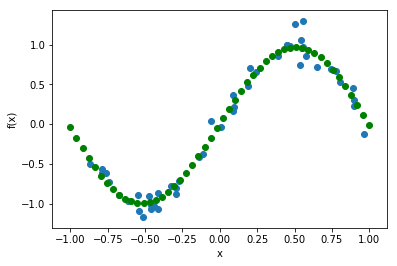

In [12]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color='green')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()

The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the model produces without being trained at all. The shape of these functions varies significantly with the variance hyperparameter for the weight initialization. 

Setting this hyperparameter to a small value produces almost linear functions, since all quantum gates in the variational circuit approximately perform the identity transformation in that case. Larger values produce smoothly oscillating functions with a period that depends on the number of layers used (generically, the more layers, the smaller the period).

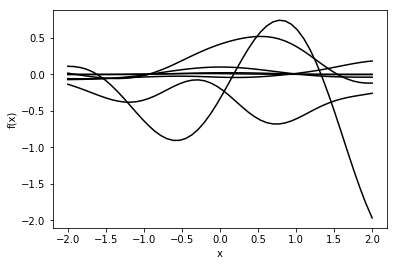

In [13]:
variance = 1.

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color='black')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.show()